In [1]:
!pip install PyMaxFlow

     |████████████████████████████████| 133kB 8.8MB/s 
  Created wheel for PyMaxFlow: filename=PyMaxflow-1.2.12-cp36-cp36m-linux_x86_64.whl size=530780 sha256=fdd20b9a380566364b68ca63a2c50d96a3db5668f62c7bbb268ddbf0832a5aee
  Stored in directory: /root/.cache/pip/wheels/56/ab/a8/12b43e2024215b384364145b140e14a838b45ad39989f51a4f
Successfully built PyMaxFlow


In [2]:
#importing all the libraries that I will use
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import numpy as np
from skimage.color import rgb2gray
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D,Flatten, Dropout
import maxflow
from sklearn.cluster import KMeans

Using TensorFlow backend.


In [0]:
#loading the training data and storing it as variable, allow pickle set to true so object arrays can be loaded.
trainingData = np.load('drive/My Drive/images/training_images.npz', allow_pickle=True)
#loading images from the training data and storing them as a variable
trainingImages = trainingData['images']
#loading points from the training data and storing them as a variable
trainingPts = trainingData['points']

In [0]:
#loading the testing data and storing it as variable, allow pickle set to true so object arrays can be loaded.
testingData = np.load('drive/My Drive/images/test_images.npz', allow_pickle=True)
#loading images from the testing data and storing them as a variable
testingImages = testingData['images']

In [0]:
#loading the example data and storing it as variable, allow pickle set to true so object arrays can be loaded.
exampleData = np.load('drive/My Drive/images/examples.npz', allow_pickle=True)
#loading images from the exaple data and storing them as a variable
exampleImages = exampleData['images']

In [0]:
#making the training images be in gray scale
trainingImages = rgb2gray(trainingImages)
#making the testing images be in gray scale
testingImages = rgb2gray(testingImages)
#making the example images be in gray scale
exampleImages = rgb2gray(exampleImages)
#sets all the training images to the same format so it can be processed by our model
trainingImages = trainingImages.astype(np.float32)
#sets all the training points to the same format so it can be processed by our model
trainingPts = trainingPts.astype(np.float32)
#sets all the testing images to the same format so it can be processed by our model
testingImages = testingImages.astype(np.float32)
#sets all the example images to the same format so it can be processed by our model
exampleImages = exampleImages.astype(np.float32)

In [0]:
#this block of code with make sure that all teh images and points from the training images are within the correct range. 
#for loop that will go through every image within training images.
for i in range(len(trainingImages)):
    #for loop that will go through all the points within every image.
    for j in range(len(trainingPts[i])):
        #for loop that will go through both coordinates within every point.
        for k in range(2):
            #if statement that checks if any coordinate is above 250 and if it is, it sets it to 250
            if(trainingPts[i][j][k] > 250):
                trainingPts[i][j][k] = 250
            #if statement that checks if any coordinate is below 0 and if it is, it sets it to 0
            if(trainingPts[i][j][k] < 0):
                trainingPts[i][j][k] = 0
#making sure that all the training points are between 1 and -1 which is used for plotting later on
trainingPts = (trainingPts - 125) / 125

In [0]:
#moving the training images to a format that can be used by my model
trainingImages = trainingImages.reshape(len(trainingImages), 250 * 250)
#moving the training points to a format that can be used by my model
trainingPts = trainingPts.reshape(len(trainingImages), 68 * 2)
#moving the testing images to a format that can be used by my model
testingImages = testingImages.reshape(len(testingImages), 250 * 250)
#moving the example images to a format that can be used by my model
exampleImages = exampleImages.reshape(len(exampleImages), 250 * 250)

In [9]:
#setting first model as new sequential object from the Keras library
firstModel = Sequential()
#this is a regular densly-connected neruaneurall network layer that also acts as the input layer.
firstModel.add(Dense(256, input_dim = trainingImages.shape[1]))
#applies an activation function to the output
firstModel.add(Activation('relu'))
#this is a regual densly-connected neural network layer that also acts as the output layer.
#it is 136 as there are 68 points which means there is 136 coordinates. 
firstModel.add(Dense(136))
#defines new stochastic gradient descent and sets the learning rate and momentum.
stochasticGradientDescent = SGD(lr = 0.01, momentum = 0.9, nesterov = True)
#compiles the model, sets the type of  loss calculated and sets the optimizer to predefined sgd
firstModel.compile(loss = 'mean_squared_error', optimizer = stochasticGradientDescent)
#this line trains the model, it receives the training images and points. Sets how many times it should run and how much data is used for validation each time. 
firstModel.fit(trainingImages, trainingPts, epochs = 250, validation_split = 0.2)

Train on 2248 samples, validate on 563 samples
Epoch 1/250
2248/2248 [==============================] - 2s 974us/step - loss: 0.0889 - val_loss: 0.0429
Epoch 2/250
2248/2248 [==============================] - 1s 257us/step - loss: 0.0196 - val_loss: 0.0134
Epoch 3/250
2248/2248 [==============================] - 1s 269us/step - loss: 0.0130 - val_loss: 0.0157
Epoch 4/250
2248/2248 [==============================] - 1s 257us/step - loss: 0.0127 - val_loss: 0.0123
Epoch 5/250
2248/2248 [==============================] - 1s 263us/step - loss: 0.0122 - val_loss: 0.0137
Epoch 6/250
2248/2248 [==============================] - 1s 266us/step - loss: 0.0114 - val_loss: 0.0131
Epoch 7/250
2248/2248 [==============================] - 1s 255us/step - loss: 0.0112 - val_loss: 0.0131
Epoch 8/250
2248/2248 [==============================] - 1s 264us/step - loss: 0.0110 - val_loss: 0.0123
Epoch 9/250
2248/2248 [==============================] - 1s 257us/step - loss: 0.0106 - val_loss: 0.0118
Epoch 10

In [0]:
#this function plots the points onto the images.
def plotter(images, points, axes):
    #reshapes and displays the images in gray scale.
    axes.imshow(images.reshape(250, 250), cmap = "gray")
    #displays the points on the image depending on the coordinates. Sets the points stile and colour.
    axes.scatter(125 * points[0::2] + 125, 125 * points[1::2] + 125, marker = '+', c = 'red')

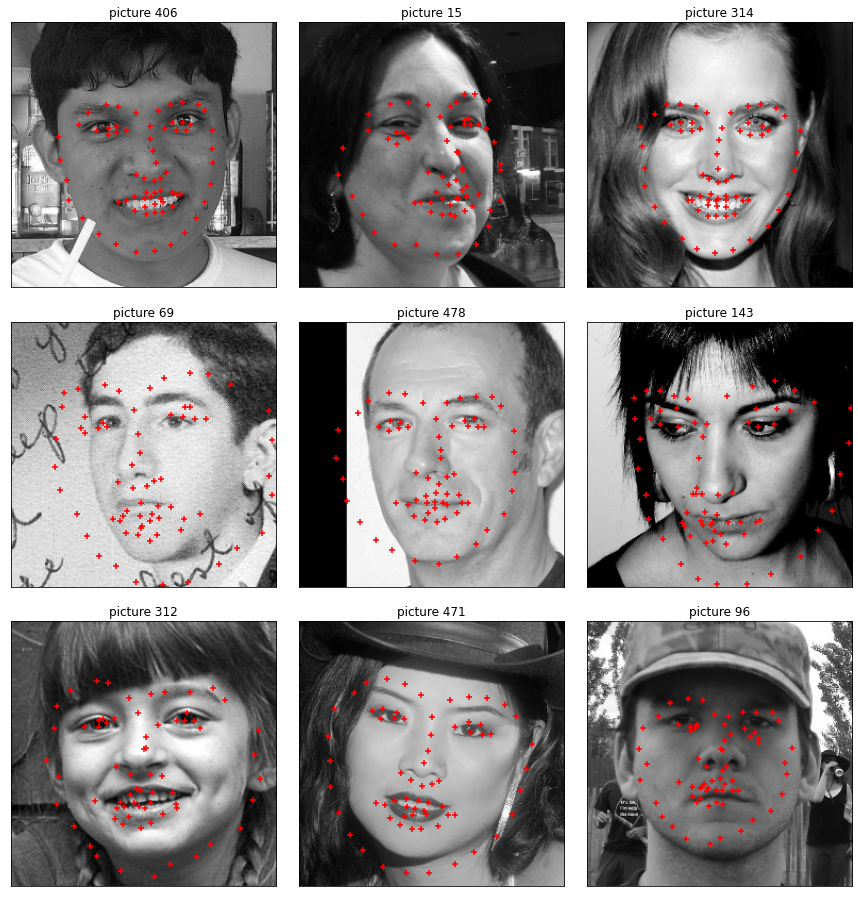

In [11]:
#predicts the points for all the images from the testing images using the first model.
pointPrediction = firstModel.predict(testingImages)
#defines the size of the figures.
figure = plt.figure(figsize = (12, 12))
#adjust different features of the figure.
figure.subplots_adjust(hspace = 0.13, wspace = 0.0001, left = 0, right = 1, bottom = 0, top = 1)
#initialises and sets the number of pictures to 9.
numberOfPictures = 9  
#initialises and sets the number for the counter to 1.
counter = 1
#for loop that goes through all the pictures set above.
for i in range(numberOfPictures):
    #initialises a variable that will store a random image from the testing images. 
    randomImage = np.random.choice(testingImages.shape[0])
    #initialises a variable that will be used to set position of each photo within the grid.
    axes = figure.add_subplot(numberOfPictures / 3, 3, counter, xticks = [], yticks = [])
    #runs the plot function and passes it the random image from testing data, as well as uses the point prediction to predict points for that random image. It also sets a postion using the axes variable.    
    plotter(testingImages[randomImage], pointPrediction[randomImage], axes)
    #sets a title of ever image to picutre and the number that represents the picutre number from the testing data.
    axes.set_title("picture " + str(randomImage))
    #counter is increased by 1
    counter += 1
#shows the images with the predicted points.
plt.show()


In [0]:
#displays a single image of my choosing
def displaySingleImage(imageNumber):
  #defines the size of the figures.
  figure = plt.figure(figsize = (12, 12))
  #adjust different features of the figure.
  figure.subplots_adjust(hspace = 0.13, wspace = 0.0001, left = 0, right = 1, bottom = 0, top = 1)
  #initialises a variable that will be used to set position of each photo within the grid.
  axes = figure.add_subplot(3, 3, 1, xticks = [], yticks = [])
  #runs the plot function and passes it the random image from testing data, as well as uses the point prediction to predict points for that random image. It also sets a postion using the axes variable.    
  plotter(testingImages[imageNumber], pointPrediction[imageNumber], axes)
  #sets a title of ever image to picutre and the number that represents the picutre number from the testing data.
  axes.set_title("picture " + str(imageNumber))
  #shows the images with the predicted points.
  plt.show()

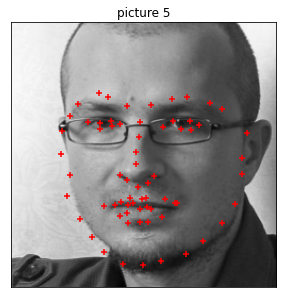

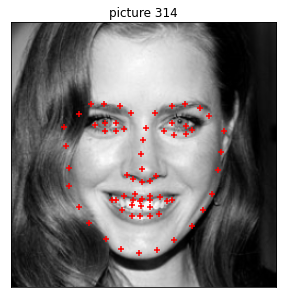

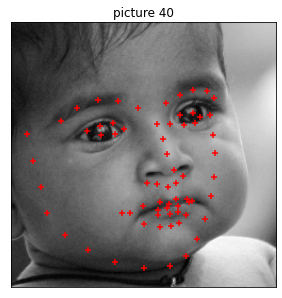

In [13]:
displaySingleImage(5)
displaySingleImage(314)
displaySingleImage(40)

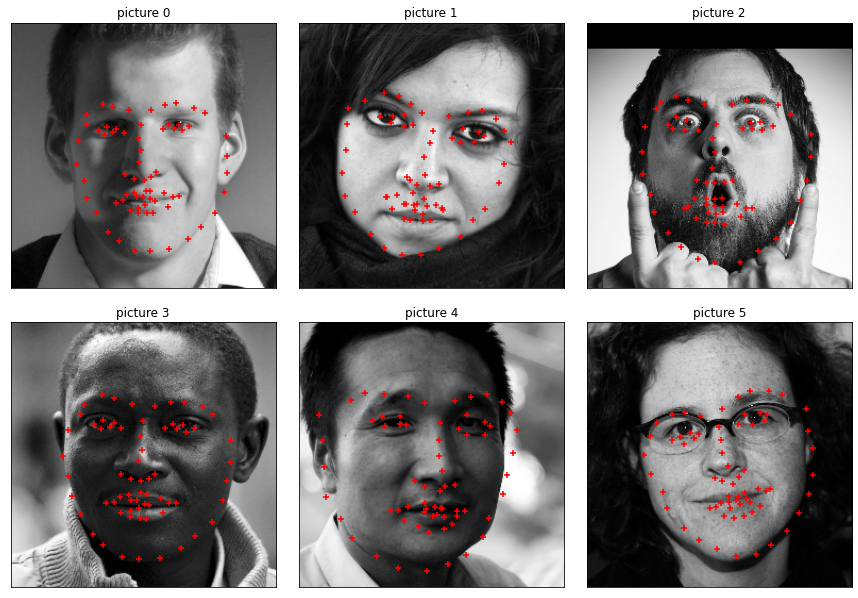

In [14]:
#predicts the points for all the images from the testing images using the first model.
pointPrediction = firstModel.predict(exampleImages)
#defines the size of the figures.
figure = plt.figure(figsize = (12, 12))
#adjust different features of the figure.
figure.subplots_adjust(hspace = 0.13, wspace = 0.0001, left = 0, right = 1, bottom = 0, top = 1)
#initialises and sets the number for the counter to 1.
counter = 1
#for loop that goes through all the pictures set above.
for i in range(len(exampleImages)):
    #initialises a variable that will be used to set position of each photo within the grid.
    axes = figure.add_subplot(6 / 2, 3, counter, xticks = [], yticks = [])
    #runs the plot function and passes it the random image from testing data, as well as uses the point prediction to predict points for that random image. It also sets a postion using the axes variable.    
    plotter(exampleImages[i], pointPrediction[i], axes)
    #sets a title of ever image to picutre and the number that represents the picutre number from the testing data.
    axes.set_title("picture " + str(i))
    #counter is increased by 1
    counter += 1
#shows the images with the predicted points.
plt.show()

In [15]:
firstModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               16000256  
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 136)               34952     
Total params: 16,035,208
Trainable params: 16,035,208
Non-trainable params: 0
_________________________________________________________________


In [0]:
def euclid_dist(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  import numpy as np
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))

In [17]:
pointPredictionForTraining = firstModel.predict(trainingImages)
pointPredictionForTraining = pointPredictionForTraining * 125 + 125
originalPointsForTraining = trainingPts.copy()
originalPointsForTraining = originalPointsForTraining * 125 + 125
np.mean(euclid_dist(pointPredictionForTraining, originalPointsForTraining))

6.9668384

In [0]:
#moving the training images to a format (4 dimensional array) that will be used by my second model.
trainingImages = trainingImages.reshape(2811, 250, 250, 1)
#moving the training points to a format that can be used by my second model
trainingPts = trainingPts.reshape(2811, 136)
#moving the testing images to a format (4 dimensional array) that will be used by my second model.
testingImages = testingImages.reshape(554, 250, 250, 1)
#moving the exaple images to a format (4 dimensional array) that will be used by my second model.
exampleImages = exampleImages.reshape(6, 250, 250, 1)

In [19]:
#setting second model as new sequential object from the Keras library
secondModel = Sequential()
#adds a 2d convolutional layer that also acts as the input layer
secondModel.add(Conv2D(32, (3, 3), input_shape = (250, 250, 1)))
#applies an activation function to the output
secondModel.add(Activation('relu'))
#adds max pooling operation for 2D spatial data. It sets pooling window size to 2x2
secondModel.add(MaxPooling2D(pool_size= (2, 2)))
#adds a 2d convolutional layer
secondModel.add(Conv2D(64, (2, 2)))
#applies an activation function to the output
secondModel.add(Activation('relu'))
#adds max pooling operation for 2D spatial data. It sets pooling window size to 2x2
secondModel.add(MaxPooling2D(pool_size= (2, 2)))
#adds a 2d convolutional layer
secondModel.add(Conv2D(128, (2, 2)))
#applies an activation function to the output
secondModel.add(Activation('relu'))
#adds max pooling operation for 2D spatial data. It sets pooling window size to 2x2
secondModel.add(MaxPooling2D(pool_size= (2, 2)))
#flattens the input without affecting the batch size
secondModel.add(Flatten())
#this is a regular densly-connected neural network layer
secondModel.add(Dense(500))
#applies an activation function to the output
secondModel.add(Activation('relu'))
#this is a regular densly-connected neural network layer
secondModel.add(Dense(500))
#applies an activation function to the output
secondModel.add(Activation('relu'))
#this is a regual densly-connected neural network layer that also acts as the output layer.
#it is 136 as there are 68 points which means there is 136 coordinates. 
secondModel.add(Dense(136))
#defines new stochastic gradient descent and sets the learning rate and momentum.
stochasticGradientDescent = SGD(lr = 0.01, momentum = 0.9, nesterov = True)
#compiles the model, sets the type of  loss calculated and sets the optimizer to predefined sgd
secondModel.compile(loss = "mean_squared_error", optimizer = stochasticGradientDescent)
#this line trains the model, it receives the training images and points. Sets how many times it should run and how much data is used for validation each time. 
secondModel.fit(trainingImages, trainingPts, epochs = 250, validation_split = 0.2)

Train on 2248 samples, validate on 563 samples
Epoch 1/250
2248/2248 [==============================] - 8s 3ms/step - loss: 0.0391 - val_loss: 0.0093
Epoch 2/250
2248/2248 [==============================] - 3s 1ms/step - loss: 0.0085 - val_loss: 0.0081
Epoch 3/250
2248/2248 [==============================] - 3s 1ms/step - loss: 0.0078 - val_loss: 0.0075
Epoch 4/250
2248/2248 [==============================] - 3s 1ms/step - loss: 0.0074 - val_loss: 0.0072
Epoch 5/250
2248/2248 [==============================] - 3s 1ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 6/250
2248/2248 [==============================] - 3s 1ms/step - loss: 0.0071 - val_loss: 0.0069
Epoch 7/250
2248/2248 [==============================] - 3s 1ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 8/250
2248/2248 [==============================] - 3s 1ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 9/250
2248/2248 [==============================] - 3s 1ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 10/250
2248/2248 [==

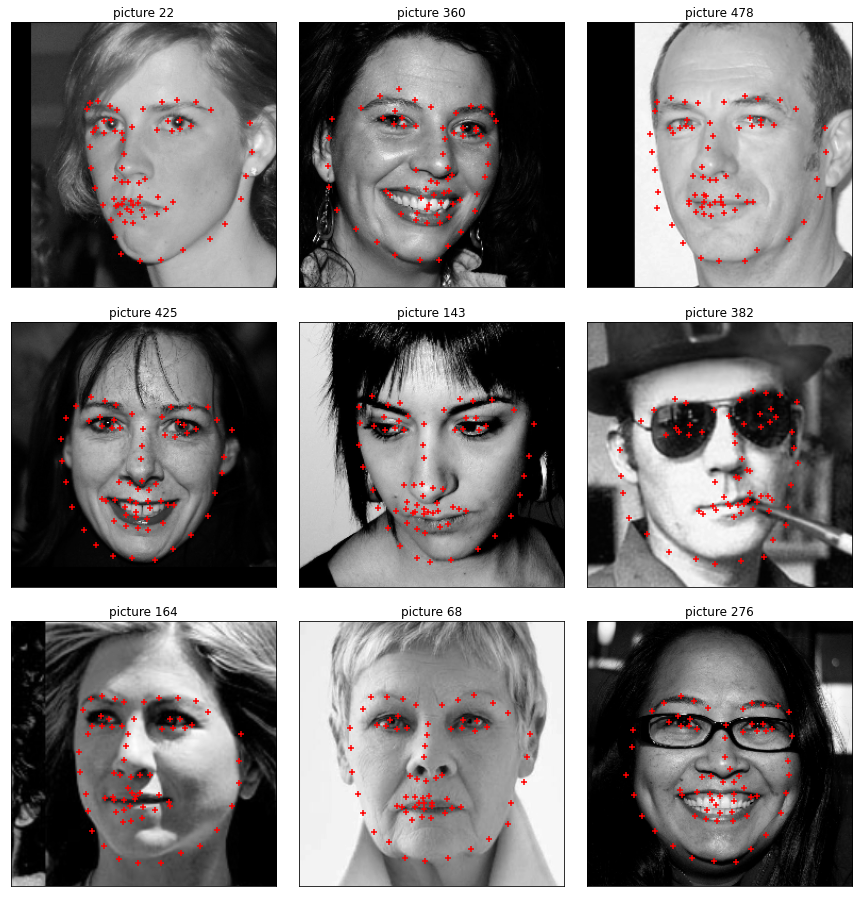

In [20]:
#predicts the points for all the images from the testing images using the second model.
pointPrediction = secondModel.predict(testingImages)
#defines the size of the figures.
figure = plt.figure(figsize=(12, 12))
#adjust different features of the figure.
figure.subplots_adjust(hspace = 0.13, wspace = 0.0001, left = 0, right = 1, bottom = 0, top = 1)
#initialises and sets the number of pictures to 9.
numberOfPictures = 9
#initialises and sets the number for the counter to 1.
counter = 1
#for loop that goes through all the pictures set above.
for i in range(numberOfPictures):
    #initialises a variable that will store a random image from the testing images. 
    randomImage = np.random.choice(testingImages.shape[0])
    #initialises a variable that will be used to set position of each photo within the grid.
    axes = figure.add_subplot(numberOfPictures / 3, 3, counter, xticks=[], yticks=[])   
    #runs the plot function and passes it the random image from testing data, as well as uses the point prediction to predict points for that random image. It also sets a postion using the axes variable.    
    plotter(testingImages[randomImage], pointPrediction[randomImage], axes)
    #sets a title of ever image to picutre and the number that represents the picutre number from the testing data.
    axes.set_title("picture " + str(randomImage))
    #counter is increased by 1
    counter += 1
#shows the images with the predicted points.
plt.show()

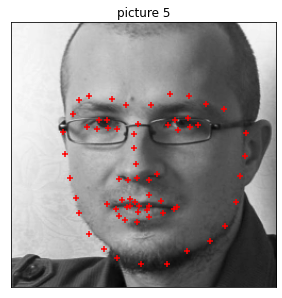

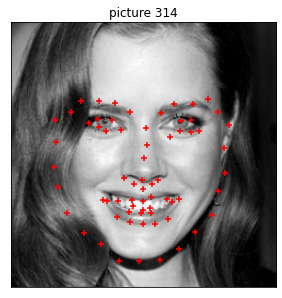

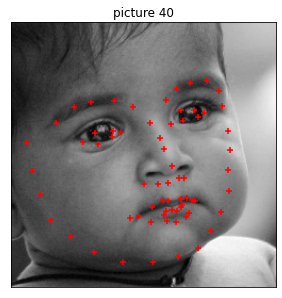

In [21]:
displaySingleImage(5)
displaySingleImage(314)
displaySingleImage(40)

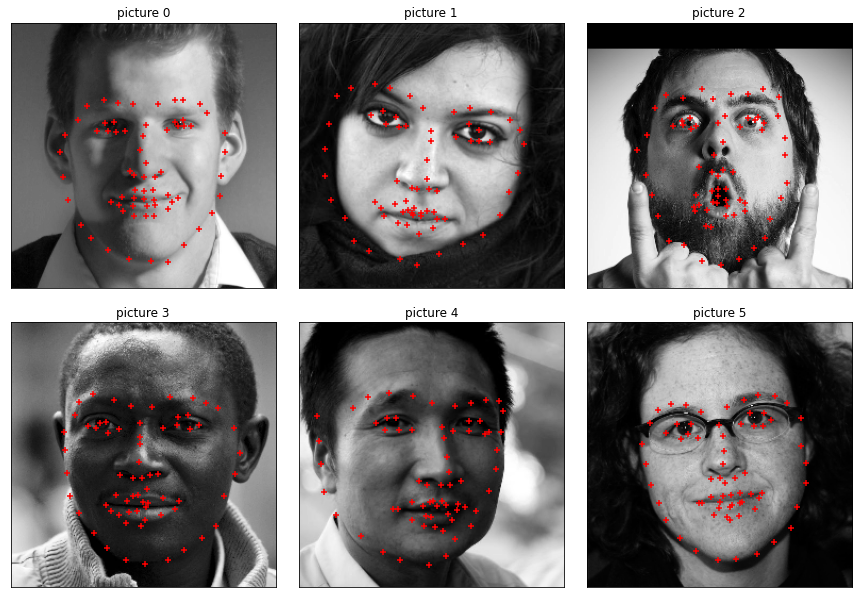

In [22]:
#predicts the points for all the images from the testing images using the second model.
pointPrediction = secondModel.predict(exampleImages)
#defines the size of the figures.
figure = plt.figure(figsize = (12, 12))
#adjust different features of the figure.
figure.subplots_adjust(hspace = 0.13, wspace = 0.0001, left = 0, right = 1, bottom = 0, top = 1)
#initialises and sets the number for the counter to 1.
counter = 1
#for loop that goes through all the pictures set above.
for i in range(len(exampleImages)):
    #initialises a variable that will be used to set position of each photo within the grid.
    axes = figure.add_subplot(6 / 2, 3, counter, xticks = [], yticks = [])
    #runs the plot function and passes it the random image from testing data, as well as uses the point prediction to predict points for that random image. It also sets a postion using the axes variable.    
    plotter(exampleImages[i], pointPrediction[i], axes)
    #sets a title of ever image to picutre and the number that represents the picutre number from the testing data.
    axes.set_title("picture " + str(i))
    #counter is increased by 1
    counter += 1
#shows the images with the predicted points.
plt.show()

In [23]:
secondModel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 248, 248, 32)      320       
_________________________________________________________________
activation_2 (Activation)    (None, 248, 248, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 123, 123, 64)      8256      
_________________________________________________________________
activation_3 (Activation)    (None, 123, 123, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 128)      

In [24]:
pointPredictionForTraining = secondModel.predict(trainingImages)
pointPredictionForTraining = pointPredictionForTraining * 125 + 125
originalPointsForTraining = trainingPts.copy()
originalPointsForTraining = originalPointsForTraining * 125 + 125
np.mean(euclid_dist(pointPredictionForTraining, originalPointsForTraining))

5.78452

In [0]:
def graphCutSegmentation(image, smoothnessWeight, whichPhoto):
  #defines the size of the figures.
  figure = plt.figure(figsize = (12, 12))
  #reshapes the image into 2 dimensional array
  photo = np.reshape(image, (62500, 3))
  #defines a KMeans with only two clusters and fits around the data
  kmeans = KMeans(n_clusters=2, random_state=0).fit(photo)
  #transforms the data into cluster-distance
  clusterDistance = kmeans.transform(photo)
  #reshapes the distance to cluseters into image form
  clusterDistance = np.reshape(clusterDistance, image.shape[0:2]+(-1,))
  #creates a new max flow graph
  graph = maxflow.Graph[float](0, 0)
  #adds nodes to each pixel within a photo
  pixedlNodes = graph.add_grid_nodes(clusterDistance.shape[0:2])
  #sets the smoothness between pixels based on the value passed into the function
  graph.add_grid_edges(pixedlNodes, smoothnessWeight)
  #sets the distances to the clusters within the graph
  graph.add_grid_tedges(pixedlNodes, clusterDistance[:,:,1], clusterDistance[:,:,0])
  #performs the max flow operation
  graph.maxflow()
  #gers the segments of the nodes in the grid
  segments = graph.get_grid_segments(pixedlNodes)
  #if 0 display only original photo
  if(whichPhoto == 0):
    plt.subplot(121)
    plt.imshow(image)
  #if 1 display only segmented photo
  elif(whichPhoto == 1):
    plt.subplot(122)
    plt.imshow(segments*1)
  #if 2 display both version of the photo
  elif(whichPhoto == 2):
    plt.subplot(121)
    plt.imshow(image)
    plt.subplot(122)
    plt.imshow(segments*1)
  else:
    print("Enter correct number!")
  #displays the graps
  plt.show()

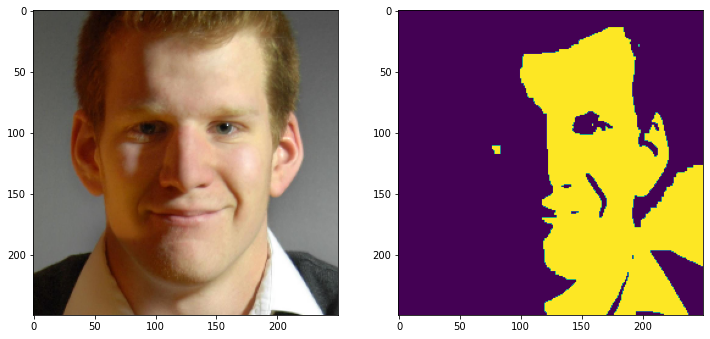

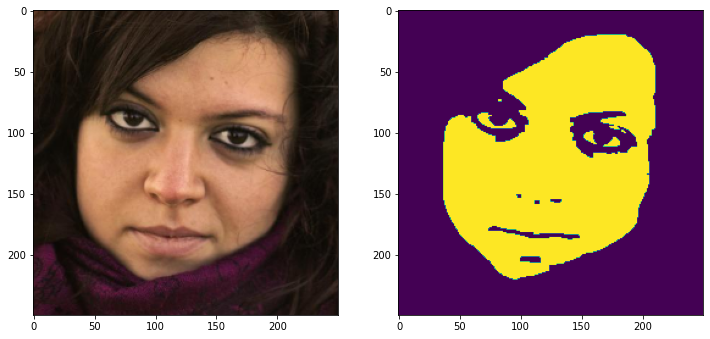

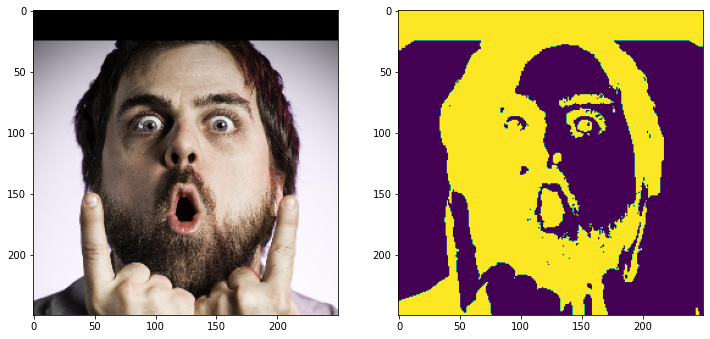

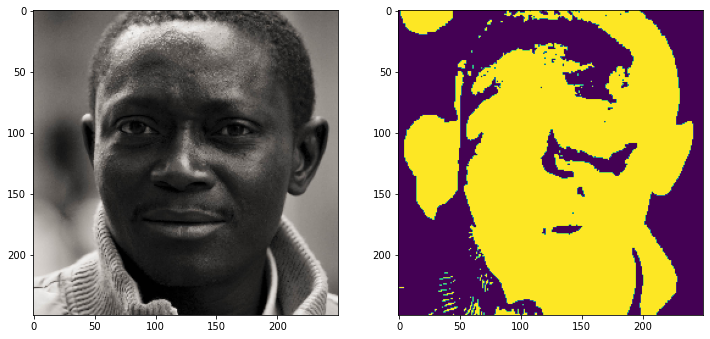

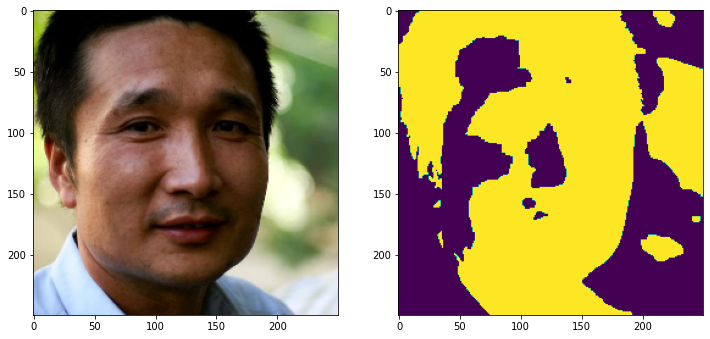

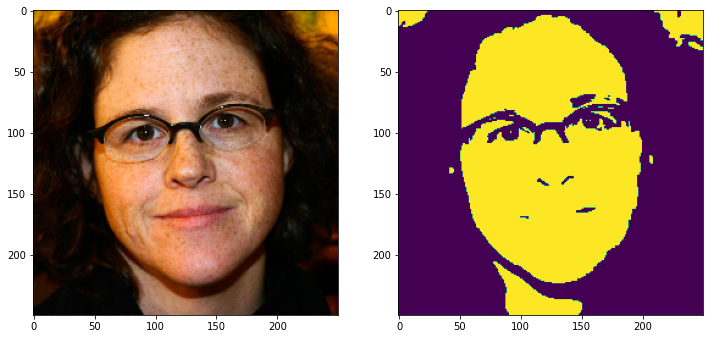

In [26]:
#for loop that will go through all example images and perform segmentation on them
for i in range(len(exampleImages)):
  colourExampleImages = exampleData['images']
  graphCutSegmentation(colourExampleImages[i], 15, 2)



In [0]:
#changes points back to displayable format
pointPrediction = pointPrediction * 125 + 125

In [0]:
#functions that adds graphical change to an image in a form of "Harry Potter" scar.
def addScarToImage(positionOfPhotos):
  #initialises a variable that will be used to set position of each photo within the grid.
  axes = figure.add_subplot(3, 3, positionOfPhotos + 1, xticks = [], yticks = [])
  #reshapes and sets the image to display in gray scale.
  axes.imshow(exampleImages[positionOfPhotos].reshape(250, 250), cmap = "gray")
  #creates coordinates for the scar
  coordinates = [[pointPrediction[positionOfPhotos][40]+3, pointPrediction[positionOfPhotos][41]-10],
                 [pointPrediction[positionOfPhotos][40]-5, pointPrediction[positionOfPhotos][41]-25], 
                 [pointPrediction[positionOfPhotos][40]+8, pointPrediction[positionOfPhotos][41]-23],
                 [pointPrediction[positionOfPhotos][40]-2, pointPrediction[positionOfPhotos][41]-38],
                 [pointPrediction[positionOfPhotos][40]+8, pointPrediction[positionOfPhotos][41]-23]]
  #saves coordinates into x and y values
  xCoordinates, yCoordinates = zip(*coordinates)
  #draw lines between coordinates and sets the color of lines to brown
  axes.plot(xCoordinates, yCoordinates, color = "brown")

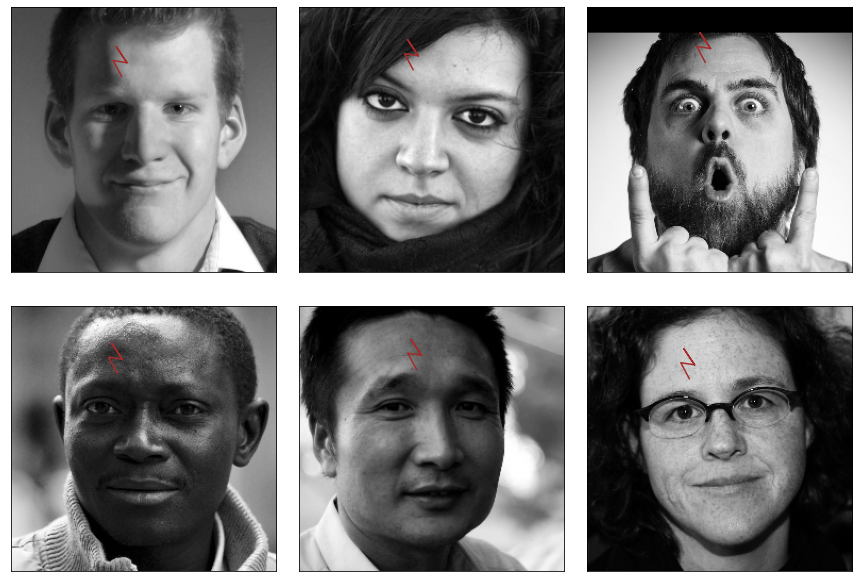

In [29]:
#defines the size of the figures.
figure = plt.figure(figsize = (12, 12))
#adjust different features of the figure.
figure.subplots_adjust(hspace = 0.13, wspace = 0.0001, left = 0, right = 1, bottom = 0, top = 1)
#for loop that goes through all example images
for i in range(len(exampleImages)):  
  addScarToImage(i)
#shows the images with the predicted points.
plt.show()